### Import the required libraries

In [1]:
import numpy as np
import pandas as pd
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from textblob import TextBlob
import spacy

### Load the datasets

In [2]:
# Function to extract the dosage details from product title
def extract_mg(producttitle):
    """ returns dosage details from product title column
    
    Args:
        producttitle (str): contains the title of a product
        
    Returns:
        mg (str): the dosage of each product in mg
    """
    
    match = re.search(r'(\d+)\s*mg', producttitle)
    return match.group(1) if match else None

In [3]:
# Create a list
dataframes = []

folder_path = 'Amazon'

# Iterate over each each file in the folder 'Amazon'
for file in os.listdir(folder_path):
    
    # Condition to check if the file is an excel file
    if file.endswith(".xlsx"):
        
        # Join the file and folder to create a path name to the file
        file_path = os.path.join(folder_path, file)
        
        # Read the excel file
        df = pd.read_excel(file_path)
        
        # Call the extract_mg() function created above and add the mg details to a new column 'MG' in dataset
        df['MG'] = df['ProductTitle'].apply(extract_mg)
        
        # Append the dataset to the list created above
        dataframes.append(df)
        
# Create a dataframe by merging all the datasets in the list     
final_df = pd.concat(dataframes, ignore_index=True)

## Data Preprocessing

### Feature Engineering

In [4]:
# Check the final dataframe
final_df.head()

,ASIN,Brand,HelpfulCounts,Images,PageUrl,ParentId,ProductLink,ProductTitle,ReviewContent,ReviewDate,ReviewScore,ReviewTitle,Reviewer,Verified,MG
0,B01E14X7SM,Natrol,3,NaN,https://www.amazon.com/product-reviews/B01E14X...,R3FO147NRH6ZT8,https://www.amazon.com/dp/B01E14X7SM,"Natrol Fast Dissolve Melatonin 10 mg, Melatoni...",I like how they are chewable and almost start ...,"November 4, 2024",5.0,Good sleep aid,Amber Phillips,True,10
1,B01E14X7SM,Natrol,37,NaN,https://www.amazon.com/product-reviews/B01E14X...,R1H89YQL3760M3,https://www.amazon.com/dp/B01E14X7SM,"Natrol Fast Dissolve Melatonin 10 mg, Melatoni...",The Natrol Melatonin 10mg Strawberry-Flavored ...,"October 31, 2023",5.0,Natrol Melatonin 10mg - My Gateway to Restful ...,Alex,True,10
2,B01E14X7SM,Natrol,6,NaN,https://www.amazon.com/product-reviews/B01E14X...,R9W5OT5FXDHAV,https://www.amazon.com/dp/B01E14X7SM,"Natrol Fast Dissolve Melatonin 10 mg, Melatoni...",These melatonin tablets are great for my sleep...,"August 12, 2024",5.0,My New Sleep Remedy,Kimmie_12,True,10
3,B01E14X7SM,Natrol,1,NaN,https://www.amazon.com/product-reviews/B01E14X...,R1ZDUMSIMVVGHM,https://www.amazon.com/dp/B01E14X7SM,"Natrol Fast Dissolve Melatonin 10 mg, Melatoni...",Yes it helps sleep so is effective no side eff...,"October 11, 2024",5.0,Frequent buyer,The pattern and material is ok but the sizing ...,True,10
4,B01E14X7SM,Natrol,4,NaN,https://www.amazon.com/product-reviews/B01E14X...,R2VGDUJE4231ZS,https://www.amazon.com/dp/B01E14X7SM,"Natrol Fast Dissolve Melatonin 10 mg, Melatoni...",Flavor was not as good as others by this compa...,"September 9, 2024",4.0,Work great but…,Emily Reid,True,10


In [5]:
# Get the shape of the dataframe
final_df.shape

(41251, 15)

In [6]:
# Get the dataframe info 
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41251 entries, 0 to 41250
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ASIN           41251 non-null  object 
 1   Brand          41251 non-null  object 
 2   HelpfulCounts  41251 non-null  object 
 3   Images         8291 non-null   object 
 4   PageUrl        41251 non-null  object 
 5   ParentId       41251 non-null  object 
 6   ProductLink    41251 non-null  object 
 7   ProductTitle   41251 non-null  object 
 8   ReviewContent  40858 non-null  object 
 9   ReviewDate     41251 non-null  object 
 10  ReviewScore    41251 non-null  float64
 11  ReviewTitle    41180 non-null  object 
 12  Reviewer       41247 non-null  object 
 13  Verified       41251 non-null  bool   
 14  MG             41251 non-null  object 
dtypes: bool(1), float64(1), object(13)
memory usage: 4.4+ MB


In [7]:
# Drop the column not required for analysis
final_df = final_df.drop(['ASIN', 'Images', 'PageUrl', 'ParentId', 'ProductLink', 'Reviewer'], axis=1)

In [8]:
# Check the remaining columns
final_df.columns

Index(['Brand', 'HelpfulCounts', 'ProductTitle', 'ReviewContent', 'ReviewDate',
       'ReviewScore', 'ReviewTitle', 'Verified', 'MG'],
      dtype='object')

In [9]:
# Drop the rows that contain NA values in the ReviewContent column
# since this is the main column for our analysis and has 393 NA values as compared to 41,251 total values
final_df = final_df.dropna(subset=['ReviewContent'])

In [10]:
# Check the NA values count again
final_df.count()

Brand            40858
HelpfulCounts    40858
ProductTitle     40858
ReviewContent    40858
ReviewDate       40858
ReviewScore      40858
ReviewTitle      40798
Verified         40858
MG               40858
dtype: int64

### Exploratory Data Analysis

### Univariate Analysis

In [11]:
# Function to extract month name
def extract_month_name(date_str):
    """ returns month from the ReviewDate column which will be used in further analysis
    
    Args:
        date_str: contains the Review Date for a Review
        
    Returns:
        month name from the regex.
    """
    
    match = re.search(r"\b(January|February|March|April|May|June|July|August|September|October|November|December)\b", date_str)
    
    if match:
        return match.group(1)  # Return the captured month name directly
    else:
        return None

In [12]:
final_df['ReviewMonth'] = final_df['ReviewDate'].apply(extract_month_name)

#### Univariate analysis for Brand.
Checking the distribution of each brand to understand which brand of Melatonin is famous among customers.

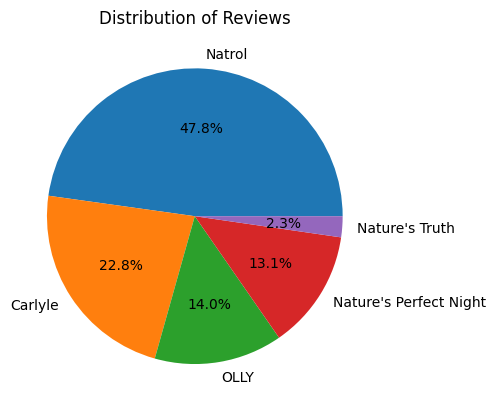

In [50]:
unique_brands = []
brands = final_df['Brand'].value_counts()

plt.pie(brands, labels = brands.index, autopct = '%1.1f%%')
plt.title('Distribution of Reviews')
plt.savefig("pie_chat1.png", format="png")

<Figure size 640x480 with 0 Axes>

Above pie chart shows that Natrol has the most reviews which could mean it has the most number of purchases and therefore the best selling brand.

This is followed by Carlyle and Nature's Perfect Night.

#### Analysis on Review Score

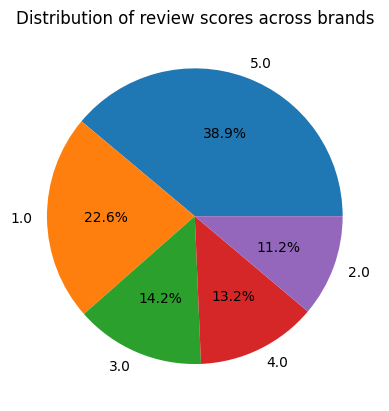

In [16]:
score = final_df['ReviewScore'].value_counts()
plt.pie(score, labels = score.index, autopct = '%1.1f%%')
plt.title('Distribution of review scores across brands')
plt.savefig("pie_chat2.png", format="png")

#### Visualisation of the review score.

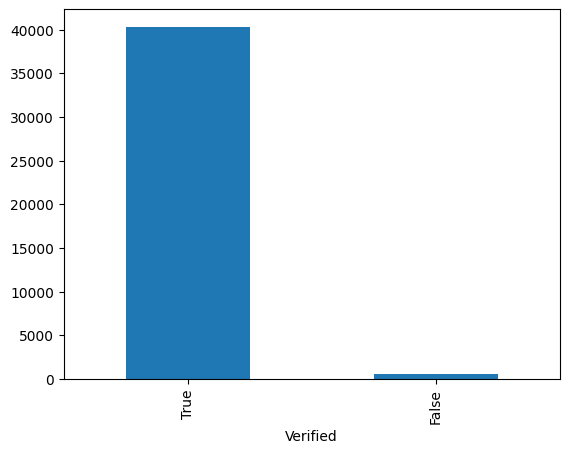

In [17]:
verified_count = final_df['Verified'].value_counts()
verified_count.plot.bar(verified_count)
plt.savefig("bar_graph1.png", format="png")

#### ReviewMonth - We have extracted the month of the review date and will analyse the month wise trend

In [19]:
def extract_date(text):
    match = re.search(r"\b(January|February|March|April|May|June|July|August|September|October|November|December) \d{1,2}, \d{4}\b", text)
    
    if match:
        return datetime.strptime(match.group(0), "%B %d, %Y")
    else:
        return None

In [20]:
final_df['ExtractedDate'] = final_df['ReviewDate'].apply(extract_date)
final_df.drop('ReviewDate', axis = 1, inplace = True)
final_df = final_df.rename(columns = {'ExtractedDate': 'ReviewDate'})

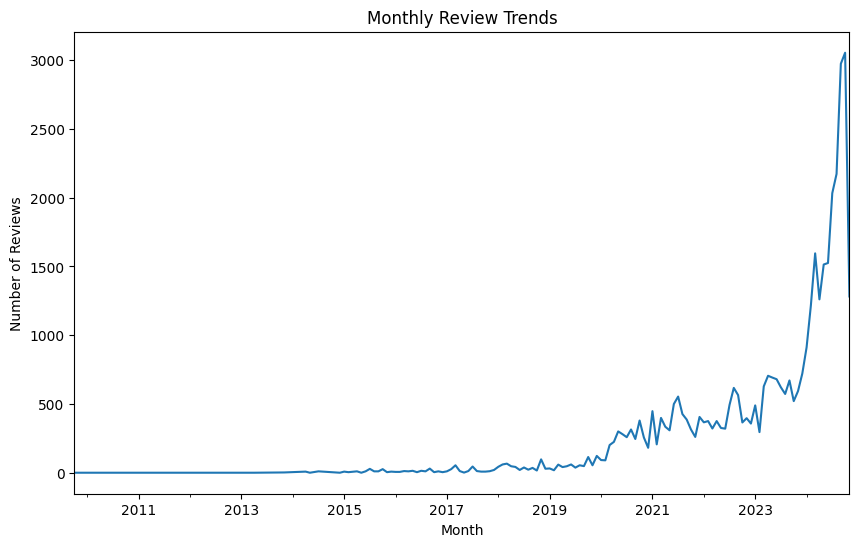

<Figure size 640x480 with 0 Axes>

In [24]:
final_df['ReviewDate'] = pd.to_datetime(final_df['ReviewDate'])
monthly_counts = final_df.groupby(final_df['ReviewDate'].dt.to_period('M')).size()
monthly_counts.plot(kind='line', figsize=(10, 6))
plt.title('Monthly Review Trends')
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.show()
plt.savefig("line_chart1.png", format="png", dpi=300, bbox_inches="tight")

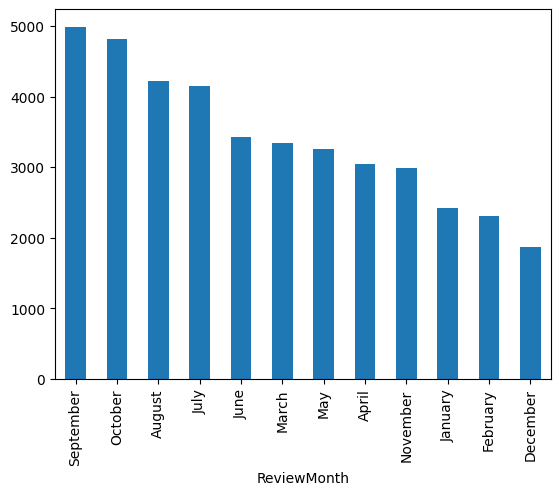

In [25]:
months = final_df['ReviewMonth'].value_counts()
months.plot.bar()
plt.savefig("bar_graph3.png", format="png", dpi=300, bbox_inches="tight")

Clearly there are more number of reviews in the month of september and least number of reviews in the month of December.

#### Bivariate Analysis

In [26]:
final_df['HelpfulCounts'] = final_df['HelpfulCounts'].str.replace(',','')
final_df['HelpfulCounts'] = pd.to_numeric(final_df['HelpfulCounts'])

               ReviewScore  HelpfulCounts
ReviewScore       1.000000       0.050107
HelpfulCounts     0.050107       1.000000


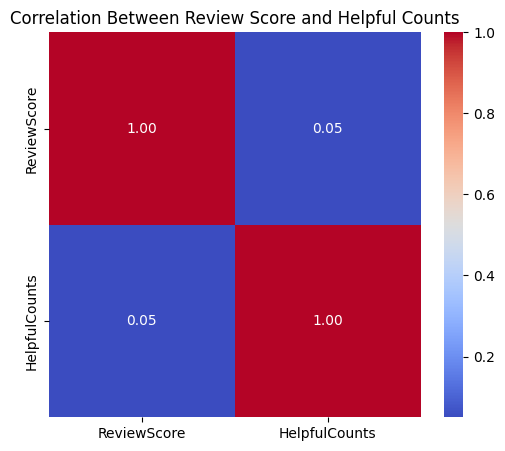

<Figure size 640x480 with 0 Axes>

In [28]:
# Correlation Matrix
corr_matrix = final_df[['ReviewScore', 'HelpfulCounts']].corr()
print(corr_matrix)

# Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Between Review Score and Helpful Counts')
plt.show()
plt.savefig("heat_map1.png", format="png", dpi=300, bbox_inches="tight")

We see her that there is no strong correlation between the ReviewScore and HelpfulCounts columns

In [29]:
final_df['ReviewLength'] = final_df['ReviewContent'].str.len()

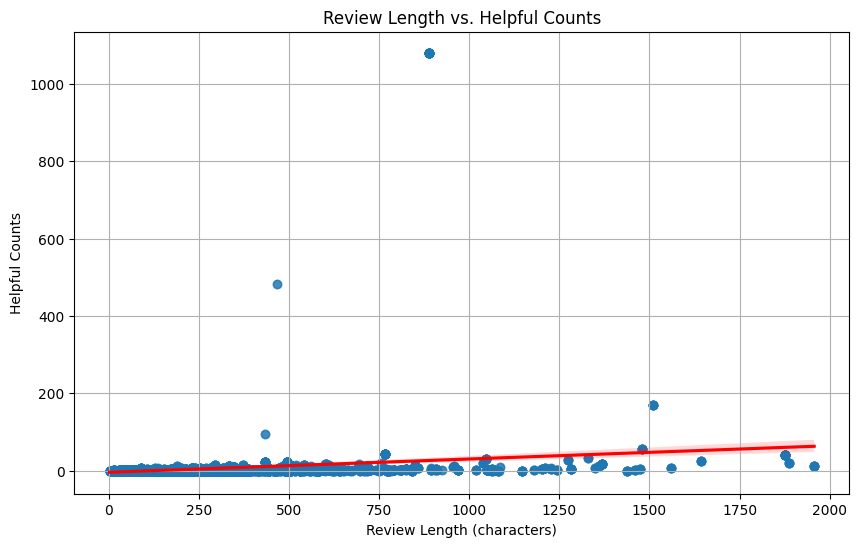

<Figure size 640x480 with 0 Axes>

In [30]:
plt.figure(figsize=(10, 6))
sns.regplot(data=final_df, x='ReviewLength', y='HelpfulCounts', scatter_kws={'alpha': 0.6}, line_kws={'color': 'red'})
plt.title('Review Length vs. Helpful Counts')
plt.xlabel('Review Length (characters)')
plt.ylabel('Helpful Counts')
plt.grid(True)
plt.show()
plt.savefig("scatter_plot1.png", format="png", dpi=300, bbox_inches="tight")

In [31]:
correlation = final_df[['ReviewLength', 'HelpfulCounts']].corr().iloc[0, 1]
correlation

np.float64(0.17642513315479164)

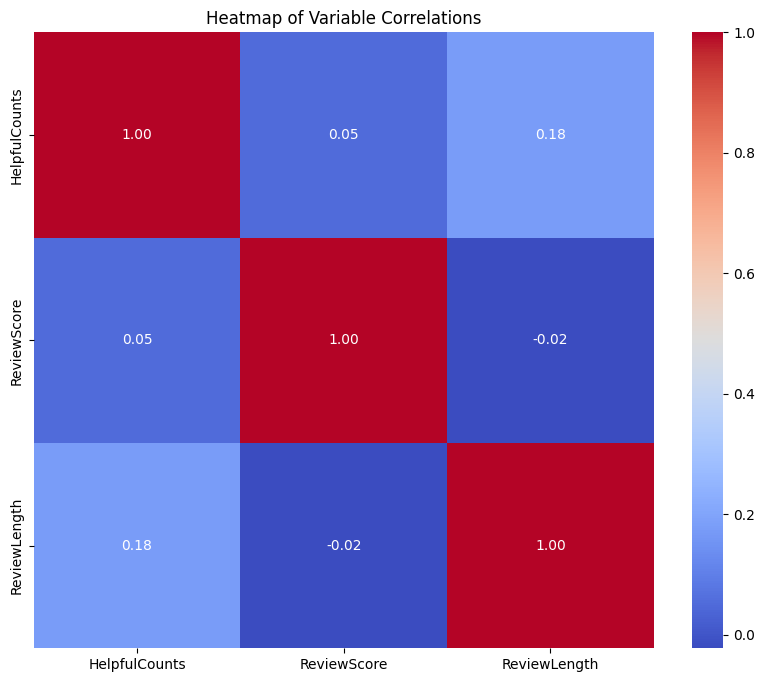

In [32]:
numerical_data = final_df.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numerical_data.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Heatmap of Variable Correlations')
plt.show()

<Axes: xlabel='MG'>

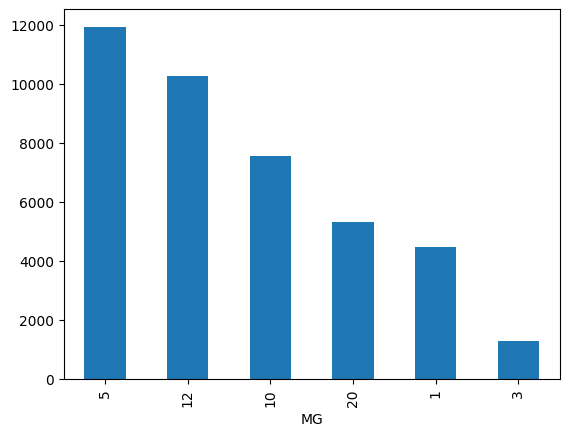

In [26]:
## Point 12 from the pdf.

mg_count = final_df['MG'].value_counts()
mg_count.plot.bar()

##### From the above plot we see that 5mg is the dosage that is most preferred by the users.

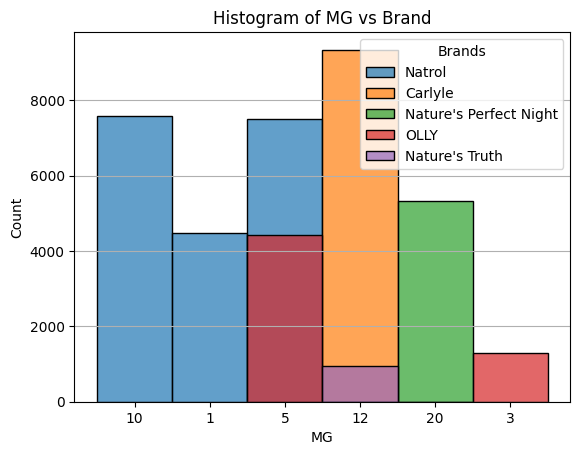

In [27]:
brands = final_df['Brand'].unique()
mg_data = final_df[['Brand', 'MG']].dropna()

for brand in brands:
    brand_data = mg_data[mg_data['Brand'] == brand]['MG']
    sns.histplot(brand_data, kde=False, label=brand, bins=len(brand_data.unique()), alpha=0.7)

plt.title('Histogram of MG vs Brand')
plt.xlabel('MG')
plt.ylabel('Count')
plt.legend(title='Brands', loc='upper right')
plt.grid(axis='y')
plt.show()

##### From the above plot we see that whenever one buys 10mg melatonin they buy it from Natrol exclusively and so is the case with 1mg. But when customers want to buy 12 mg melatonin, they tend to gravitate towards the Brands Carlyle and Nature's Truth.

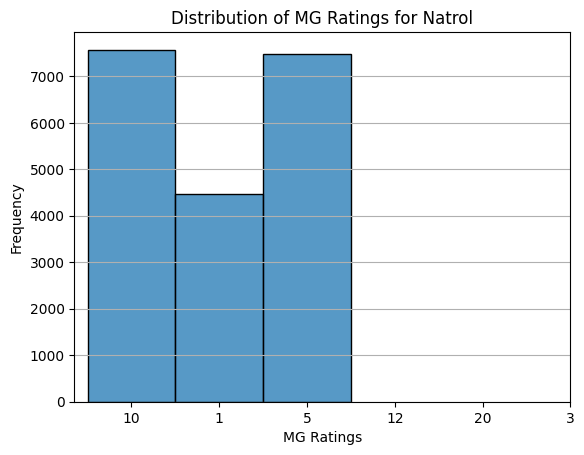

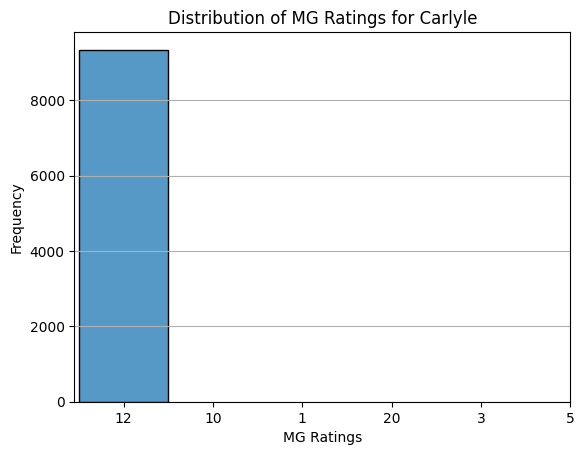

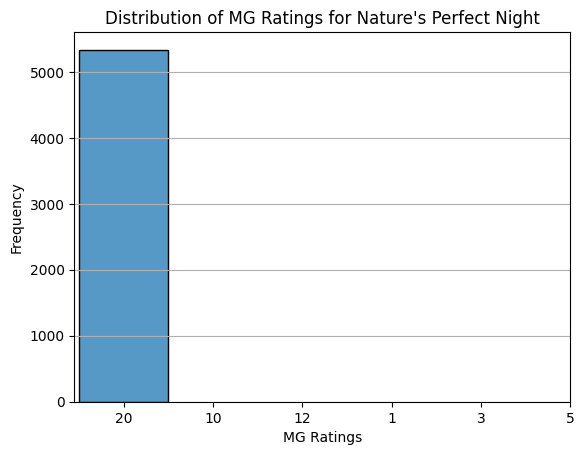

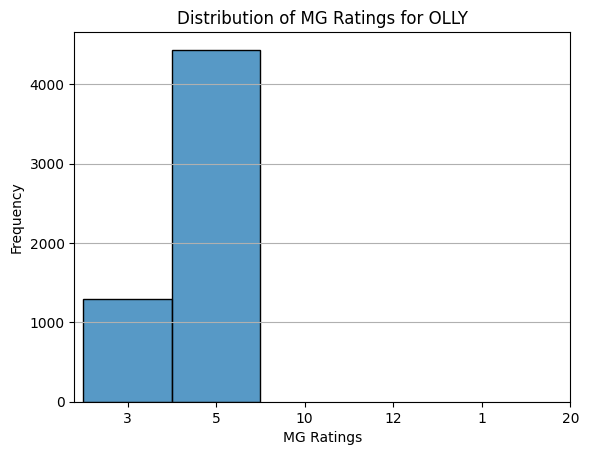

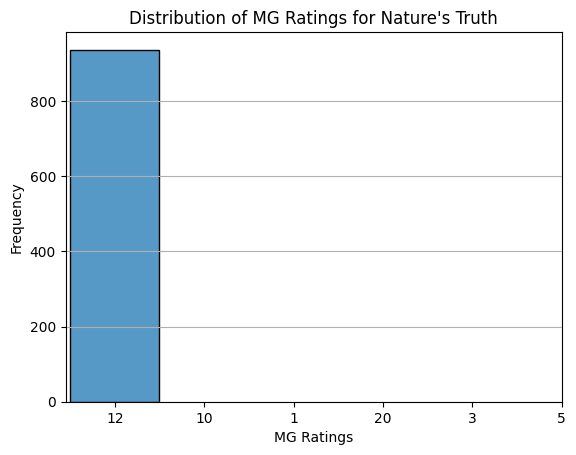

In [28]:
mg_bins = final_df.MG.unique()
for brand in brands:
    brand_data = mg_data[mg_data['Brand'] == brand]['MG']
    sns.histplot(brand_data, kde=False, bins=mg_bins)
    plt.title(f'Distribution of MG Ratings for {brand}')
    plt.xlabel('MG Ratings')
    plt.ylabel('Frequency')
    plt.xticks(mg_bins)
    plt.grid(axis='y')
    plt.show()

##### From the previous plot we see here that people buy 10mg and 1 mg from Natrol because there are no other brands selling this dosage. And similar is the case with other mg. No single brand has all of the dosage.

## Natural Language Processing

#### Data Cleaning and Manipulation

In [33]:
# Initialize NLTK tools
stopwords = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [34]:
# Function for text preprocessing
def process_text(text):
    """ returns cleaned reviews after processing the ReviewContent column in the dataframe. The reviews are transformed to
    lower case, punctuations and stop words are removed, tokenized, stemmed and lemmatized.
    
    Args:
        text (str): contains the reviews from the ReviewContent column
        
    Returns:
        joined tokens (str): the cleaned reviews for analysis
    """
        
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation    
    text = ''.join([char for char in text if char not in string.punctuation and char not in "’"])
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stop words
    tokens = [word for word in tokens if word not in stopwords]
    
    # Stemming: Reduce words to their root form
    #tokens = [stemmer.stem(word) for word in tokens]
    
    # Lemmatization: Get the base form of the word
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Join the tokens back into a string
    return " ".join(tokens)

In [35]:
# Call the process_text() function to clean the text in the 'ReviewContent' column
processed_text = final_df['ReviewContent'].apply(process_text)

In [36]:
# Check the cleaned data
processed_text[0:10]

0    like chewable almost start working immediately...
1    natrol melatonin 10mg strawberryflavored dieta...
2    melatonin tablet great sleepless night taste t...
3    yes help sleep effective side effect easily ch...
4    flavor good others company tolerable bit surpr...
5    take one night im sure help fall asleep quickl...
6    love natural way help sleep great value money ...
7    take 10mhg every night go sleep effective help...
8    reason melatonin brand work veritable horse do...
9    husband like dont use found need take two stay...
Name: ReviewContent, dtype: object

In [37]:
# Function for getting the most common words
def common_words(processed_text, num_commonwords):
    """ returns the top n words that are used the most in the reviews
    
    Args:
        processed_text (str): contains the cleaned reviews returned from the process_text() function
        num_commonwords (int) : the number of top words in the reviews that should be returned
        
    Returns:
        commonwords (str): a list of most common words in all the reviews
    """
    
    # Tokenize the processed text
    tokens = [word_tokenize(word) for word in processed_text]
    
    # Create list of all words
    all_words = []
    [all_words.extend(word_list) for word_list in tokens]
    
    # Count the frequency of each word using Counter
    word_counts = Counter(all_words)

    # Get the most common words
    most_common_words = word_counts.most_common(num_commonwords)
    
    # Create a list of common words
    commonwords = [words for words,count in most_common_words]
    
    return commonwords

In [38]:
# Call the common_words() function defined above to get the common words in reviews
commonwords = common_words(processed_text, 10)
commonwords

['sleep',
 'work',
 'melatonin',
 'taste',
 'product',
 'night',
 'take',
 'like',
 'asleep',
 'one']

In [39]:
# Function to remove the common words from reviews
def remove_common_words(processed_text):
    """ returns the final cleaned reviews after removing the most common words
    
    Args:
        processed_text (str): contains the cleaned reviews returned from the process_text() function
        
    Returns:
        final_text (str): the final cleaned text of various reviews required for analysis
    """
    
    # Tokenize the processed text
    tokenlist = [word_tokenize(word) for word in processed_text]
    
    outer_token_list = []
    
    for singlelist in tokenlist:
        inner_token_list = []
        
        # Iterate over each word from the list
        for word in singlelist:
            
            # Condition to check if word is not common word defined above
            if word not in commonwords:
                
                # If word is not common, append to inner list to create list of uncommon words
                inner_token_list.append(word)
        
        # Appending to create a list of lists without uncommon words 
        outer_token_list.append(inner_token_list)
    
    # here we join the words in inner list to form reviews, giving list of reviews
    final_text = [' '.join(token) for token in outer_token_list]
    
    return final_text

In [40]:
# Create a column ReviewContentClean containing the final clean text returned from remove_common_words() function
final_df['ReviewContentClean'] = remove_common_words(processed_text)

In [41]:
# Check the dataframe
final_df.head()

,Brand,HelpfulCounts,ProductTitle,ReviewContent,ReviewScore,ReviewTitle,Verified,MG,ReviewMonth,ReviewDate,ReviewLength,ReviewContentClean
0,Natrol,NaN,"Natrol Fast Dissolve Melatonin 10 mg, Melatoni...",I like how they are chewable and almost start ...,5.0,Good sleep aid,True,10,November,2024-11-04,273,chewable almost start working immediately easy...
1,Natrol,NaN,"Natrol Fast Dissolve Melatonin 10 mg, Melatoni...",The Natrol Melatonin 10mg Strawberry-Flavored ...,5.0,Natrol Melatonin 10mg - My Gateway to Restful ...,True,10,October,2023-10-31,2381,natrol 10mg strawberryflavored dietary supplem...
2,Natrol,NaN,"Natrol Fast Dissolve Melatonin 10 mg, Melatoni...",These melatonin tablets are great for my sleep...,5.0,My New Sleep Remedy,True,10,August,2024-08-12,301,tablet great sleepless took getting used theyv...
3,Natrol,NaN,"Natrol Fast Dissolve Melatonin 10 mg, Melatoni...",Yes it helps sleep so is effective no side eff...,5.0,Frequent buyer,True,10,October,2024-10-11,175,yes help effective side effect easily chewed s...
4,Natrol,NaN,"Natrol Fast Dissolve Melatonin 10 mg, Melatoni...",Flavor was not as good as others by this compa...,4.0,Work great but…,True,10,September,2024-09-09,97,flavor good others company tolerable bit surpr...


#### N Grams

In [42]:
# Function to create n-grams contiguous sequence of n number of words
def ngram_words(clean_reviews, n):
    """ returns the words and frequencies for the contiguous sequence of the specified n number of words
    
    Args:
        clean_reviews (str): contains the cleaned reviews from the ReviewContentClean column
        n (int): number of words required in the sequence
        
    Returns:
        topwordsdf (df): dataframe of top 20 words and their frequencies
    """
    
    # Create a CountVectorizer for generating n-grams of size `n`
    cvect = CountVectorizer(ngram_range=(n,n), max_features=2000).fit(clean_reviews)
    
    # Transform the cleaned reviews into a bag-of-words sparse matrix
    bag_of_words = cvect.transform(clean_reviews)
    
    # Calculate the total occurrences of each n-gram across the cleaned reviews
    sum_words = bag_of_words.sum(axis=0) 
    
    # Create a list of tuples containing each n-gram and its corresponding frequency
    words_freq = [(word, sum_words[0, idx]) for word, idx in cvect.vocabulary_.items()]
    
    # Sort the n-grams by their frequencies in descending order
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    # Extract the top 20 most frequent n-grams
    topwords = words_freq[:20]
    
    # Create a dataframe of these top words and their frequencies
    topwordsdf = pd.DataFrame(topwords, columns=['Words', 'Frequency'])
    
    return topwordsdf

In [43]:
# Call the ngram_words() function to get the top words in 1 word sequence
# Printing the dataframe to get the frequencies of top 20 words 
topn1words = ngram_words(final_df['ReviewContentClean'], n=1)
topn1words

,Words,Frequency
0,help,7234
1,good,7133
2,get,6556
3,pill,6550
4,bottle,6516
5,time,6401
6,dont,6137
7,im,5682
8,tablet,5632
9,ive,5587


In [44]:
# Call the ngram_words() function to get the top words in 2 word sequence
topn2words = ngram_words(final_df['ReviewContentClean'], n=2) 

In [45]:
# Call the ngram_words() function to get the top words in 3 word sequence
topn3words = ngram_words(final_df['ReviewContentClean'], n=3)

In [46]:
# Funtion to create bar graph of words vs frequency 
def ngrams_graph(word_freq_df):
    """ returns the bar graph for specified n-gram words vs frequencies using the seaborn and matplotlib libraries
    
    Args:
        word_freq_df (str): dataframe of n-gram words and frequencies
        
    Returns:
        fig (image): bar graph of n-gram words vs frequency of the words
    """
        
    fig = plt.figure(figsize = (10, 5))
    
    plot=sns.barplot(x="Words",y="Frequency", data= word_freq_df.sort_values('Frequency', ascending = False))
    plot.set_xticklabels(rotation=75, labels = word_freq_df.sort_values('Frequency', ascending=False).Words)
    
    plt.title("Most frequently used words in Review Content", y = 1.07, fontsize = 17)

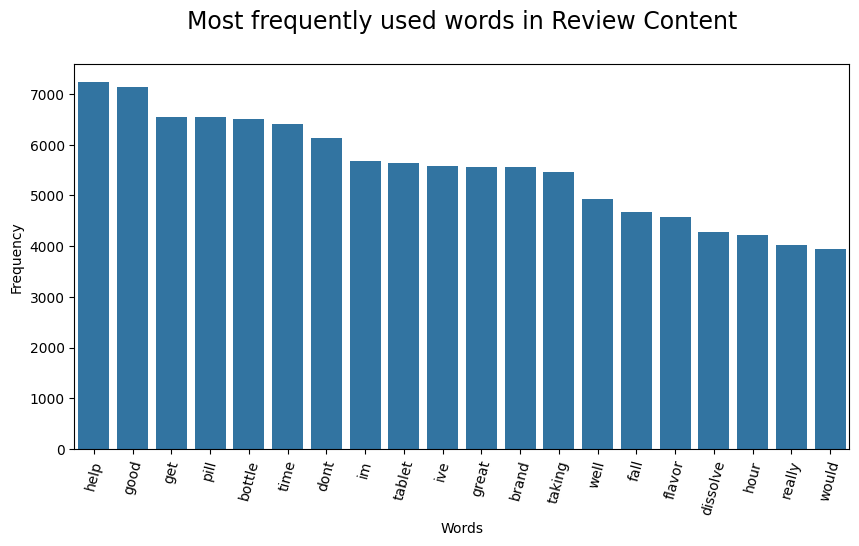

In [47]:
# Call the ngrams_graph() function to get the graph for top words in 1 word sequence vs their frequencies
graphn1words = ngrams_graph(topn1words)
graphn1words

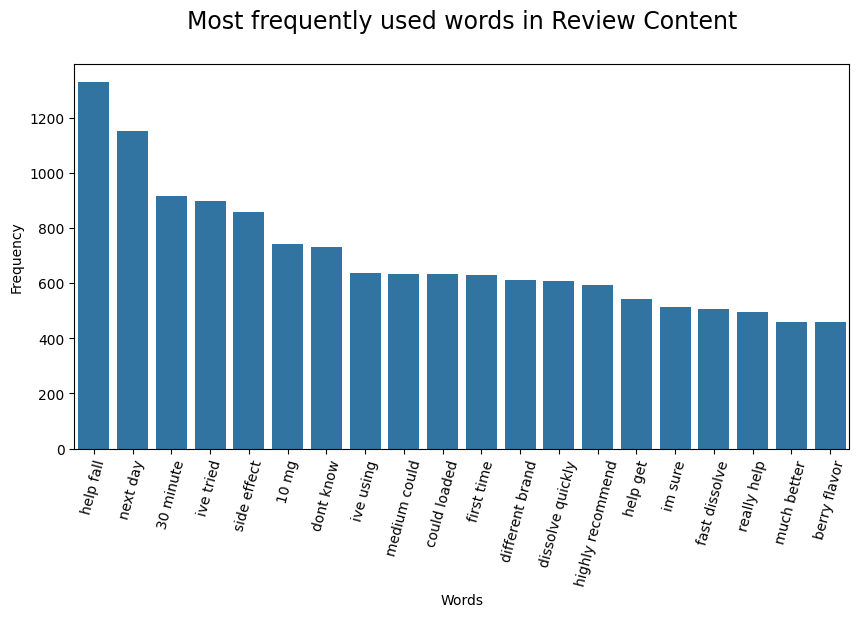

In [48]:
# Call the ngrams_graph() function to get the graph for top words in 2 word sequence vs their frequencies
graphn2words = ngrams_graph(topn2words)
graphn2words

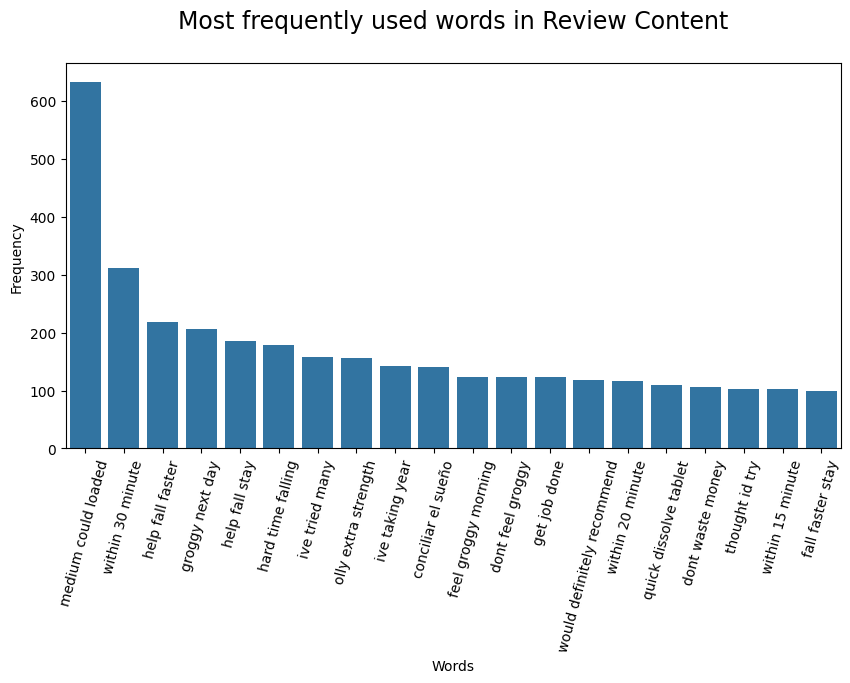

In [49]:
# Call the ngrams_graph() function to get the graph for top words in 3 word sequence vs their frequencies
graphn3words = ngrams_graph(topn3words)
graphn3words

#### Word Cloud

In [51]:
# Create a string of all the clean reviews joined
fullreviews = " ".join(final_df["ReviewContentClean"])

Text(0.5, 1.07, 'WordCloud of the words used in Reviews')

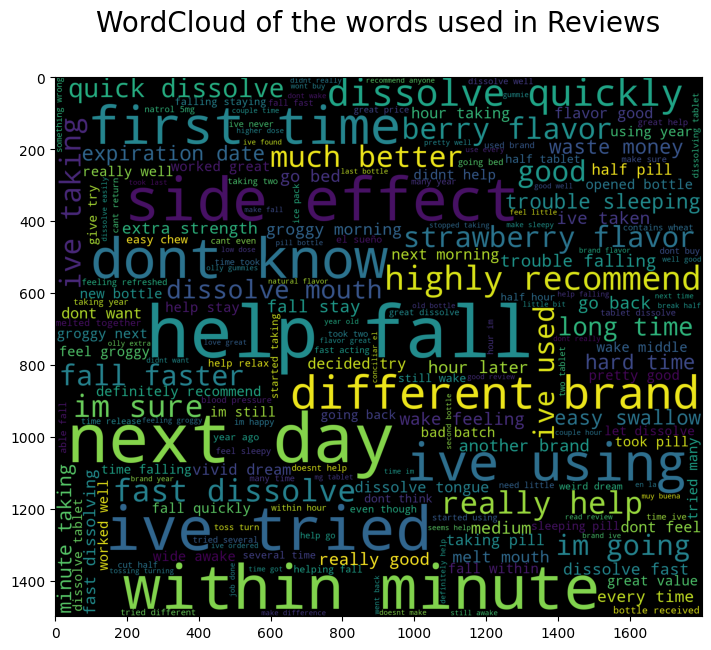

In [52]:
# Create the word cloud of the words used in the reviews
fig = plt.figure(figsize = (15,7))

wordcloud = WordCloud(
                background_color= 'black',
                width = 1800,
                height = 1500, random_state = 10, max_font_size = 200
                ).generate(fullreviews)

plt.imshow(wordcloud)
plt.title("WordCloud of the words used in Reviews", y=1.07, fontsize=20)

#### Sentiment Analysis

In [53]:
# Funtions to get the subjectivity and polarity of the cleaned reviews
def get_subjectivity(text):
    """ returns the subjectivity score for each review in the dataframe
    
    Args:
        text (str): cleaned reviews
        
    Returns:
        subjectivity (float): subjectivity score for each review
    """
    
    return TextBlob(text).sentiment.subjectivity


def get_polarity(text):
    """ returns the polarity score for each review in the dataframe
    
    Args:
        text (str): cleaned reviews
        
    Returns:
        subjectivity (float): polarity score for each review
    """
    
    return TextBlob(text).sentiment.polarity

In [54]:
# Call the get_subjectivity() and get_polarity() functions to get the subjectivity and polarity score, create columns of scores
final_df['Subjectivity'] = final_df['ReviewContentClean'].apply(get_subjectivity)
final_df['Polarity'] = final_df['ReviewContentClean'].apply(get_polarity)

In [55]:
# Check the dataframe having the subjectivity and polarity scores
final_df.head()

,Brand,HelpfulCounts,ProductTitle,ReviewContent,ReviewScore,ReviewTitle,Verified,MG,ReviewMonth,ReviewDate,ReviewLength,ReviewContentClean,Subjectivity,Polarity
0,Natrol,NaN,"Natrol Fast Dissolve Melatonin 10 mg, Melatoni...",I like how they are chewable and almost start ...,5.0,Good sleep aid,True,10,November,2024-11-04,273,chewable almost start working immediately easy...,0.597222,0.227778
1,Natrol,NaN,"Natrol Fast Dissolve Melatonin 10 mg, Melatoni...",The Natrol Melatonin 10mg Strawberry-Flavored ...,5.0,Natrol Melatonin 10mg - My Gateway to Restful ...,True,10,October,2023-10-31,2381,natrol 10mg strawberryflavored dietary supplem...,0.539600,0.319067
2,Natrol,NaN,"Natrol Fast Dissolve Melatonin 10 mg, Melatoni...",These melatonin tablets are great for my sleep...,5.0,My New Sleep Remedy,True,10,August,2024-08-12,301,tablet great sleepless took getting used theyv...,0.500758,0.389394
3,Natrol,NaN,"Natrol Fast Dissolve Melatonin 10 mg, Melatoni...",Yes it helps sleep so is effective no side eff...,5.0,Frequent buyer,True,10,October,2024-10-11,175,yes help effective side effect easily chewed s...,0.726667,0.366667
4,Natrol,NaN,"Natrol Fast Dissolve Melatonin 10 mg, Melatoni...",Flavor was not as good as others by this compa...,4.0,Work great but…,True,10,September,2024-09-09,97,flavor good others company tolerable bit surpr...,0.750000,0.400000


In [56]:
# Funtion to bifurcate the sentiments as positive, negative or neutral depending on the polarity score
def get_sentiments(polarityscore):
    """ returns the sentiments in terms of positive, negative or neutral based on the polarity score
    
    Args:
        polarityscore (float): the polarity scores returned by the get_polarity function
        
    Returns:
        sentiments (str): sentiments as positive, negative or neutral
    """
    
    # Return 'positive' if polarity score is greater than 0, 'neutral' if score is equal to 0 and 
    # 'negative' if score is less than 0
    if polarityscore < 0:
        return 'Negative'
    elif polarityscore == 0:
        return 'Neutral'
    elif polarityscore > 0:
        return 'Positive'

In [57]:
# Call the get_sentiments() function to get the sentiments, create a new column having these returned sentiments
final_df['Sentiments'] = final_df['Polarity'].apply(get_sentiments) 

In [58]:
# Check the dataframe having the Sentiments column
final_df.head()

,Brand,HelpfulCounts,ProductTitle,ReviewContent,ReviewScore,ReviewTitle,Verified,MG,ReviewMonth,ReviewDate,ReviewLength,ReviewContentClean,Subjectivity,Polarity,Sentiments
0,Natrol,NaN,"Natrol Fast Dissolve Melatonin 10 mg, Melatoni...",I like how they are chewable and almost start ...,5.0,Good sleep aid,True,10,November,2024-11-04,273,chewable almost start working immediately easy...,0.597222,0.227778,Positive
1,Natrol,NaN,"Natrol Fast Dissolve Melatonin 10 mg, Melatoni...",The Natrol Melatonin 10mg Strawberry-Flavored ...,5.0,Natrol Melatonin 10mg - My Gateway to Restful ...,True,10,October,2023-10-31,2381,natrol 10mg strawberryflavored dietary supplem...,0.539600,0.319067,Positive
2,Natrol,NaN,"Natrol Fast Dissolve Melatonin 10 mg, Melatoni...",These melatonin tablets are great for my sleep...,5.0,My New Sleep Remedy,True,10,August,2024-08-12,301,tablet great sleepless took getting used theyv...,0.500758,0.389394,Positive
3,Natrol,NaN,"Natrol Fast Dissolve Melatonin 10 mg, Melatoni...",Yes it helps sleep so is effective no side eff...,5.0,Frequent buyer,True,10,October,2024-10-11,175,yes help effective side effect easily chewed s...,0.726667,0.366667,Positive
4,Natrol,NaN,"Natrol Fast Dissolve Melatonin 10 mg, Melatoni...",Flavor was not as good as others by this compa...,4.0,Work great but…,True,10,September,2024-09-09,97,flavor good others company tolerable bit surpr...,0.750000,0.400000,Positive


##### TF-IDF vectorizer is being used here to get a classification model using logistic regression.

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Extract features using TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)  # Use top 1000 terms
X = vectorizer.fit_transform(final_df['ReviewContent'])

y = final_df['Sentiments'].map({'Positive': 1, 'Neutral': 0, 'Negative': -1})

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Logistic Regression
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [55]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.95      0.88      0.92      2525
           0       0.95      0.94      0.94      2492
           1       0.95      0.98      0.96      7241

    accuracy                           0.95     12258
   macro avg       0.95      0.93      0.94     12258
weighted avg       0.95      0.95      0.95     12258



In [59]:
positive_reviews = final_df[final_df['Sentiments'] == 'Positive']
positive_reviews = positive_reviews.sort_values('Polarity', ascending = False)

positive_reviews.head(2)

,Brand,HelpfulCounts,ProductTitle,ReviewContent,ReviewScore,ReviewTitle,Verified,MG,ReviewMonth,ReviewDate,ReviewLength,ReviewContentClean,Subjectivity,Polarity,Sentiments
15244,Carlyle,0.0,Carlyle Melatonin 12 mg Fast Dissolve 180 Tabl...,This stuff seems to work best for me to help m...,5.0,Works,True,12,September,2024-09-25,54,stuff seems best help,0.3,1.0,Positive
34779,Natrol,NaN,"Natrol Fast Dissolve Melatonin 5 mg, Melatonin...",Helps me fall asleep every night. Best favor.,5.0,Effective,True,5,September,2024-09-16,45,help fall every best favor,0.3,1.0,Positive


In [60]:
# Filter the dataframe for the negavtive reviews
negative_reviews = final_df[final_df['Sentiments'] == 'Negative']

# Sort the dataframe based on the ascending polarity score
negative_reviews = negative_reviews.sort_values('Polarity', ascending = True)

# Print the negative reviews
negative_reviews.head(2)

,Brand,HelpfulCounts,ProductTitle,ReviewContent,ReviewScore,ReviewTitle,Verified,MG,ReviewMonth,ReviewDate,ReviewLength,ReviewContentClean,Subjectivity,Polarity,Sentiments
25117,Nature's Perfect Night,NaN,Nature's Perfect Night | Melatonin 20mg | 180 ...,This is just horrible tasting candy. Doesn't w...,1.0,Doesn't work.,True,20,November,2022-11-28,50,horrible tasting candy doesnt,1.0,-1.0,Negative
7504,Natrol,NaN,"Natrol Fast Dissolve Melatonin 10 mg, Melatoni...",If I could I would return these. They taste t...,2.0,Taste terrible.,True,10,September,2024-09-26,93,could would return terrible might throw trash,1.0,-1.0,Negative


In [61]:
# Get the percentage of the positive and negative reviews
print("Percentage of positive reviews:", round((positive_reviews.shape[0]/final_df.shape[0])*100, 1), "%")
print("Percentage of negative reviews:", round((negative_reviews.shape[0]/final_df.shape[0])*100, 1), "%")

Percentage of positive reviews: 59.6 %
Percentage of negative reviews: 20.3 %


Text(0, 0.5, 'Number or Reviews')

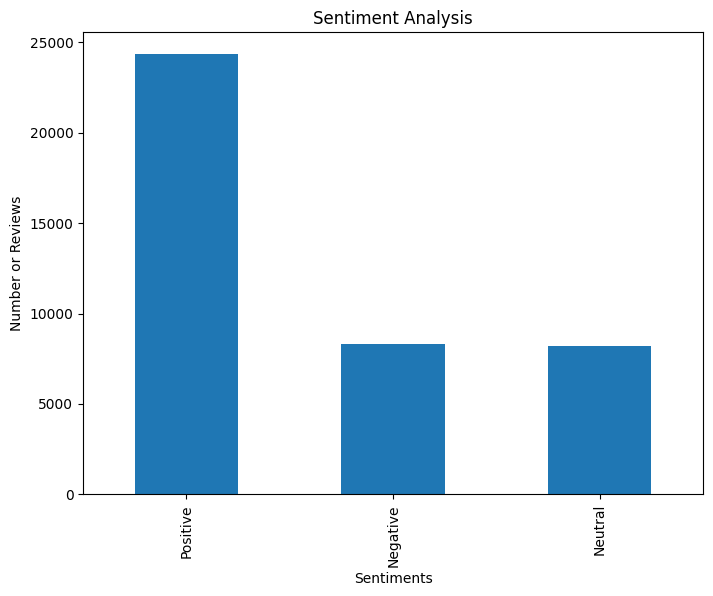

In [62]:
# Get the bar graph of sentiments vs the count of reviews
plt.figure(figsize=(8,6))

final_df['Sentiments'].value_counts().plot(kind='bar')

plt.title("Sentiment Analysis")
plt.xlabel('Sentiments')
plt.ylabel('Number or Reviews')

#### The below dataframe is used to indicate the percentage of positive and negative reviews for each of te brand that there is in the dataframe

In [63]:
positive_threshold = 4
# positive_reviews=lambda x: (x >= positive_threshold).sum()
# negative_reviews = lambda x: (x< positive_threshold).sum()

review_summary = (
    final_df.groupby('Brand')['ReviewScore'].agg(total_reviews='count', positive_reviews = lambda x: (x >= positive_threshold).sum(),
                                                 negative_reviews = lambda x: (x< positive_threshold).sum()))

review_summary['positive %'] = (review_summary['positive_reviews'] / review_summary['total_reviews']) * 100
review_summary['negative %'] = (review_summary['negative_reviews'] / review_summary['total_reviews']) * 100
review_summary = review_summary.reset_index()
review_summary

,Brand,total_reviews,positive_reviews,negative_reviews,positive %,negative %
0,Carlyle,9336,4938,4398,52.892031,47.107969
1,Natrol,19525,9569,9956,49.008963,50.991037
2,Nature's Perfect Night,5336,2988,2348,55.997001,44.002999
3,Nature's Truth,936,792,144,84.615385,15.384615
4,OLLY,5725,2993,2732,52.279476,47.720524


#### Plotting the graph of positive and negative reviews per brand 

This allows us to asses which brand usually has better reviews, thus helping customers make their decisions

<Figure size 1200x600 with 0 Axes>

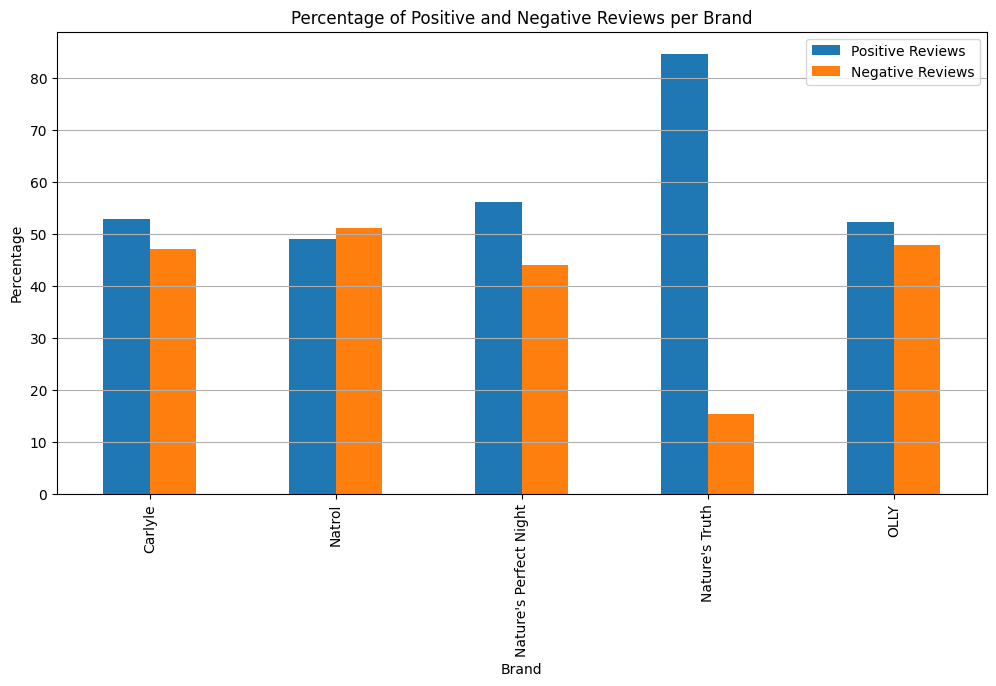

In [64]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
review_summary.plot(x='Brand',y=['positive %', 'negative %'],kind='bar',figsize=(12, 6))

plt.title('Percentage of Positive and Negative Reviews per Brand')
plt.xlabel('Brand')
plt.ylabel('Percentage')
plt.legend(['Positive Reviews', 'Negative Reviews'])
plt.grid(axis='y')
plt.show()

### Distribution of review scores per brand

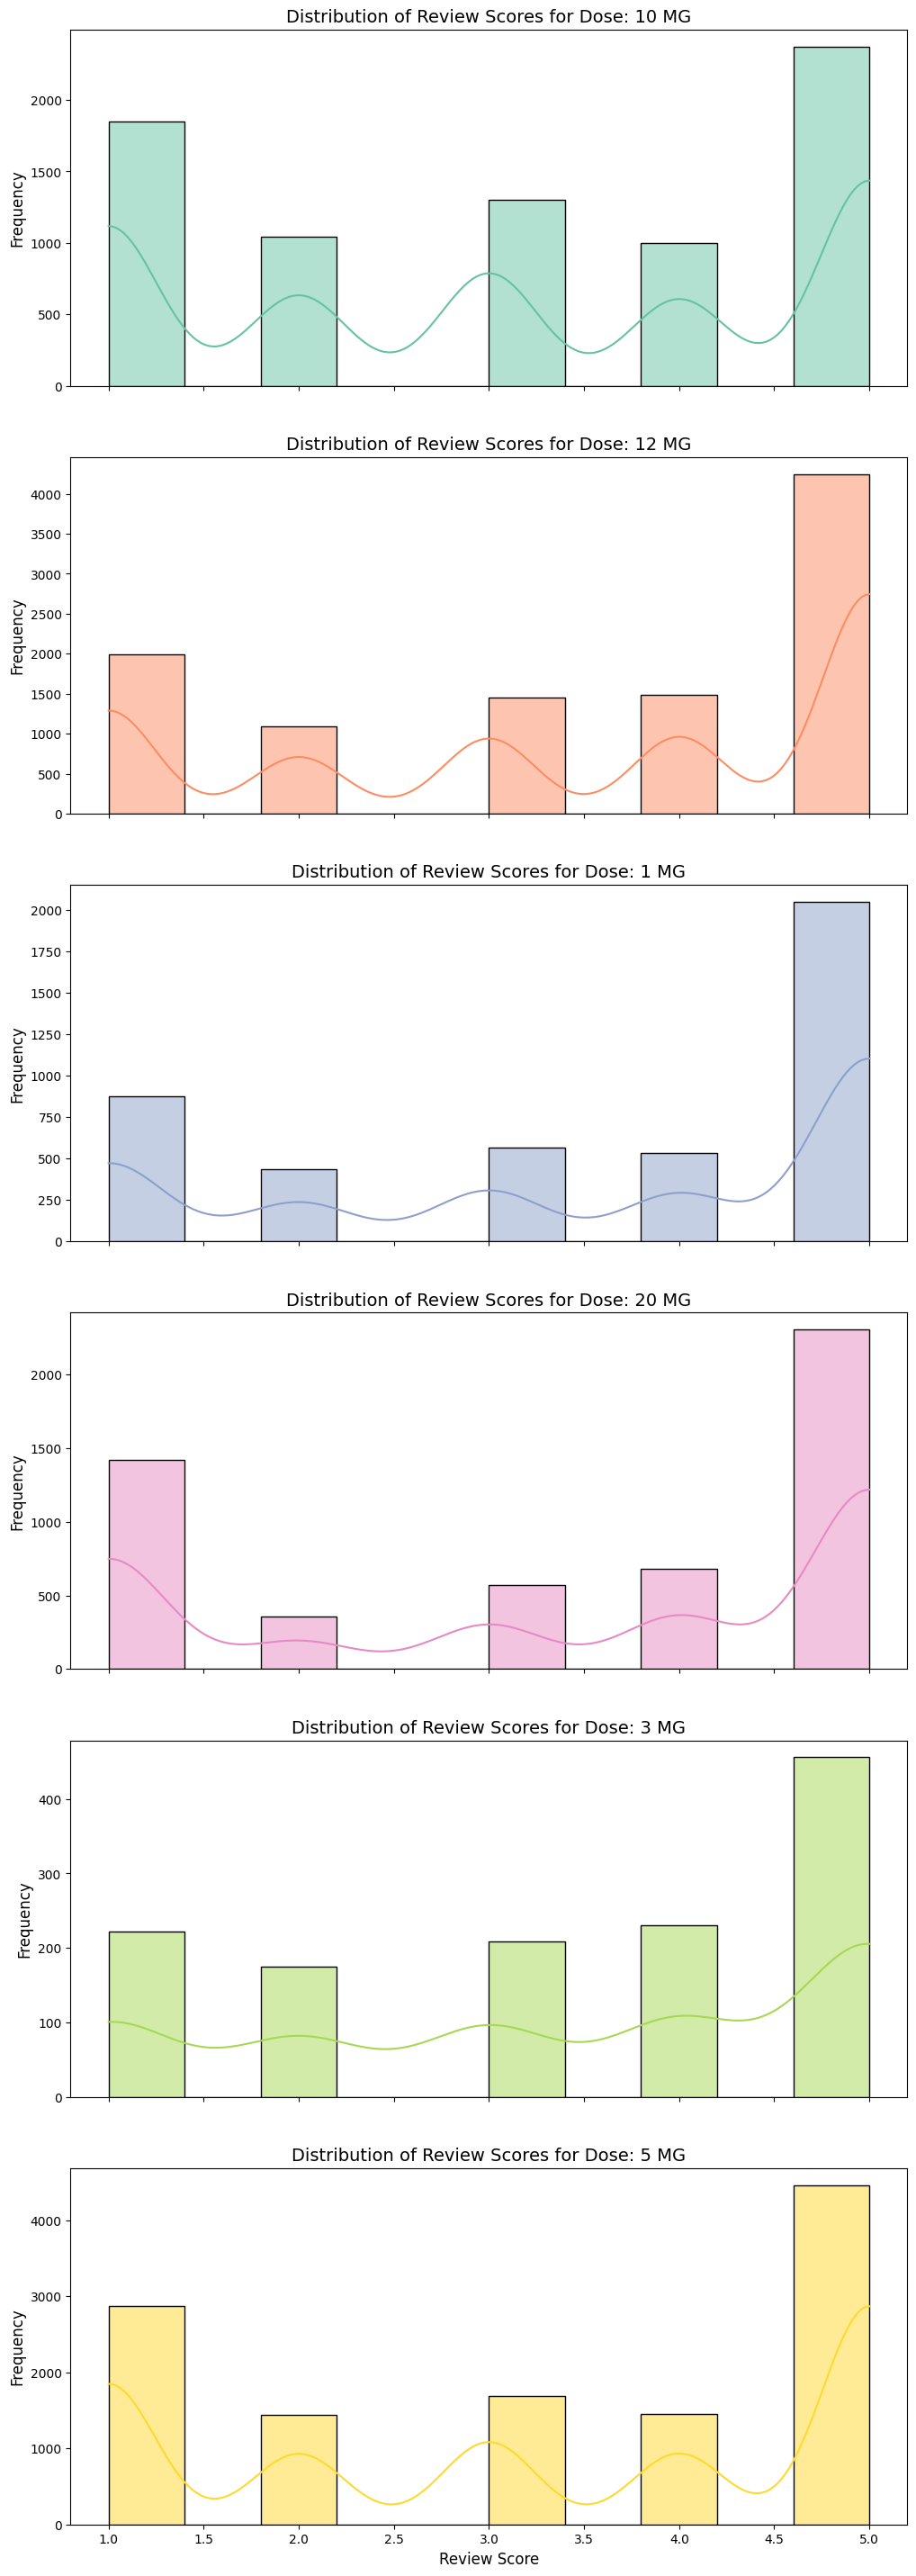

In [65]:
unique_doses = final_df['MG'].dropna().unique()

fig, axes = plt.subplots(nrows=len(unique_doses), ncols=1, figsize=(12, 6 * len(unique_doses)), sharex=True)

for i, dose in enumerate(unique_doses):
    ax = axes[i]
    dose_data = final_df[final_df['MG'] == dose]
    
    # Plot histogram with KDE
    sns.histplot(data=dose_data, x='ReviewScore', kde=True, bins=10, ax=ax, color=sns.color_palette("Set2")[i])
    

    ax.set_title(f"Distribution of Review Scores for Dose: {dose} MG", fontsize=14)
    ax.set_xlabel("Review Score", fontsize=12)
    ax.set_ylabel("Frequency", fontsize=12)

plt.show()

####  Sentiment of each dose

In [66]:
# Get the mean polarity for each dose Grouping the dosage in MG, create a new dataframe for this use case
dose_sentiments = final_df.groupby('MG')['Polarity'].mean().reset_index()
dose_sentiments

,MG,Polarity
0,1,0.156445
1,10,0.117531
2,12,0.161317
3,20,0.134114
4,3,0.128092
5,5,0.152775


In [67]:
# Call the get_sentiments() function to get the sentiments, create a new column having these returned sentiments
dose_sentiments['Sentiments'] = dose_sentiments['Polarity'].apply(get_sentiments)
dose_sentiments

,MG,Polarity,Sentiments
0,1,0.156445,Positive
1,10,0.117531,Positive
2,12,0.161317,Positive
3,20,0.134114,Positive
4,3,0.128092,Positive
5,5,0.152775,Positive


#### Average rating per dose

In [68]:
average_rating_by_MG = final_df.groupby('MG')['ReviewScore'].mean().reset_index()
average_rating_by_MG.columns = ['MG', 'AverageReviewScore']
average_rating_by_MG

,MG,AverageReviewScore
0,1,3.548142
1,10,3.133122
2,12,3.476051
3,20,3.392991
4,3,3.405112
5,5,3.266588


### Preferred dosages by the customers

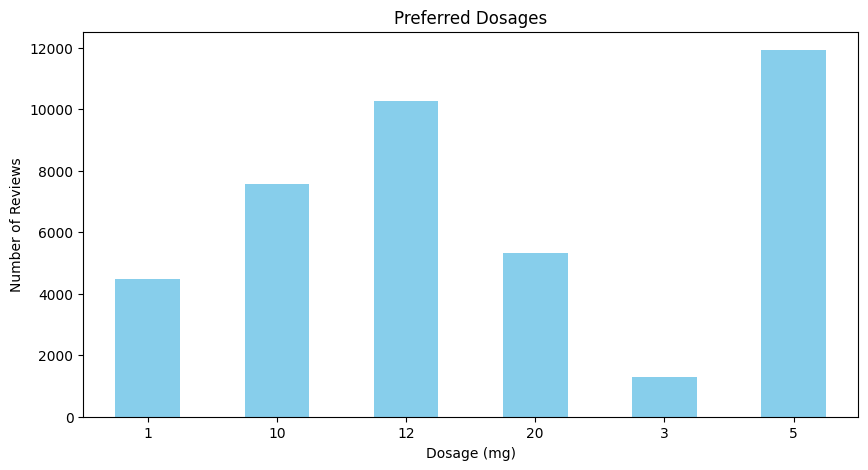

In [69]:
dosage_counts = final_df['MG'].value_counts().sort_index()

# Plot the results
plt.figure(figsize=(10, 5))
dosage_counts.plot(kind='bar', color='skyblue')
plt.title('Preferred Dosages')
plt.xlabel('Dosage (mg)')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.show()

##### We see that the two most used dosages are 12 mg and 5 mg

#### Trends in review score per brand over time. Measured after grouping by the years 

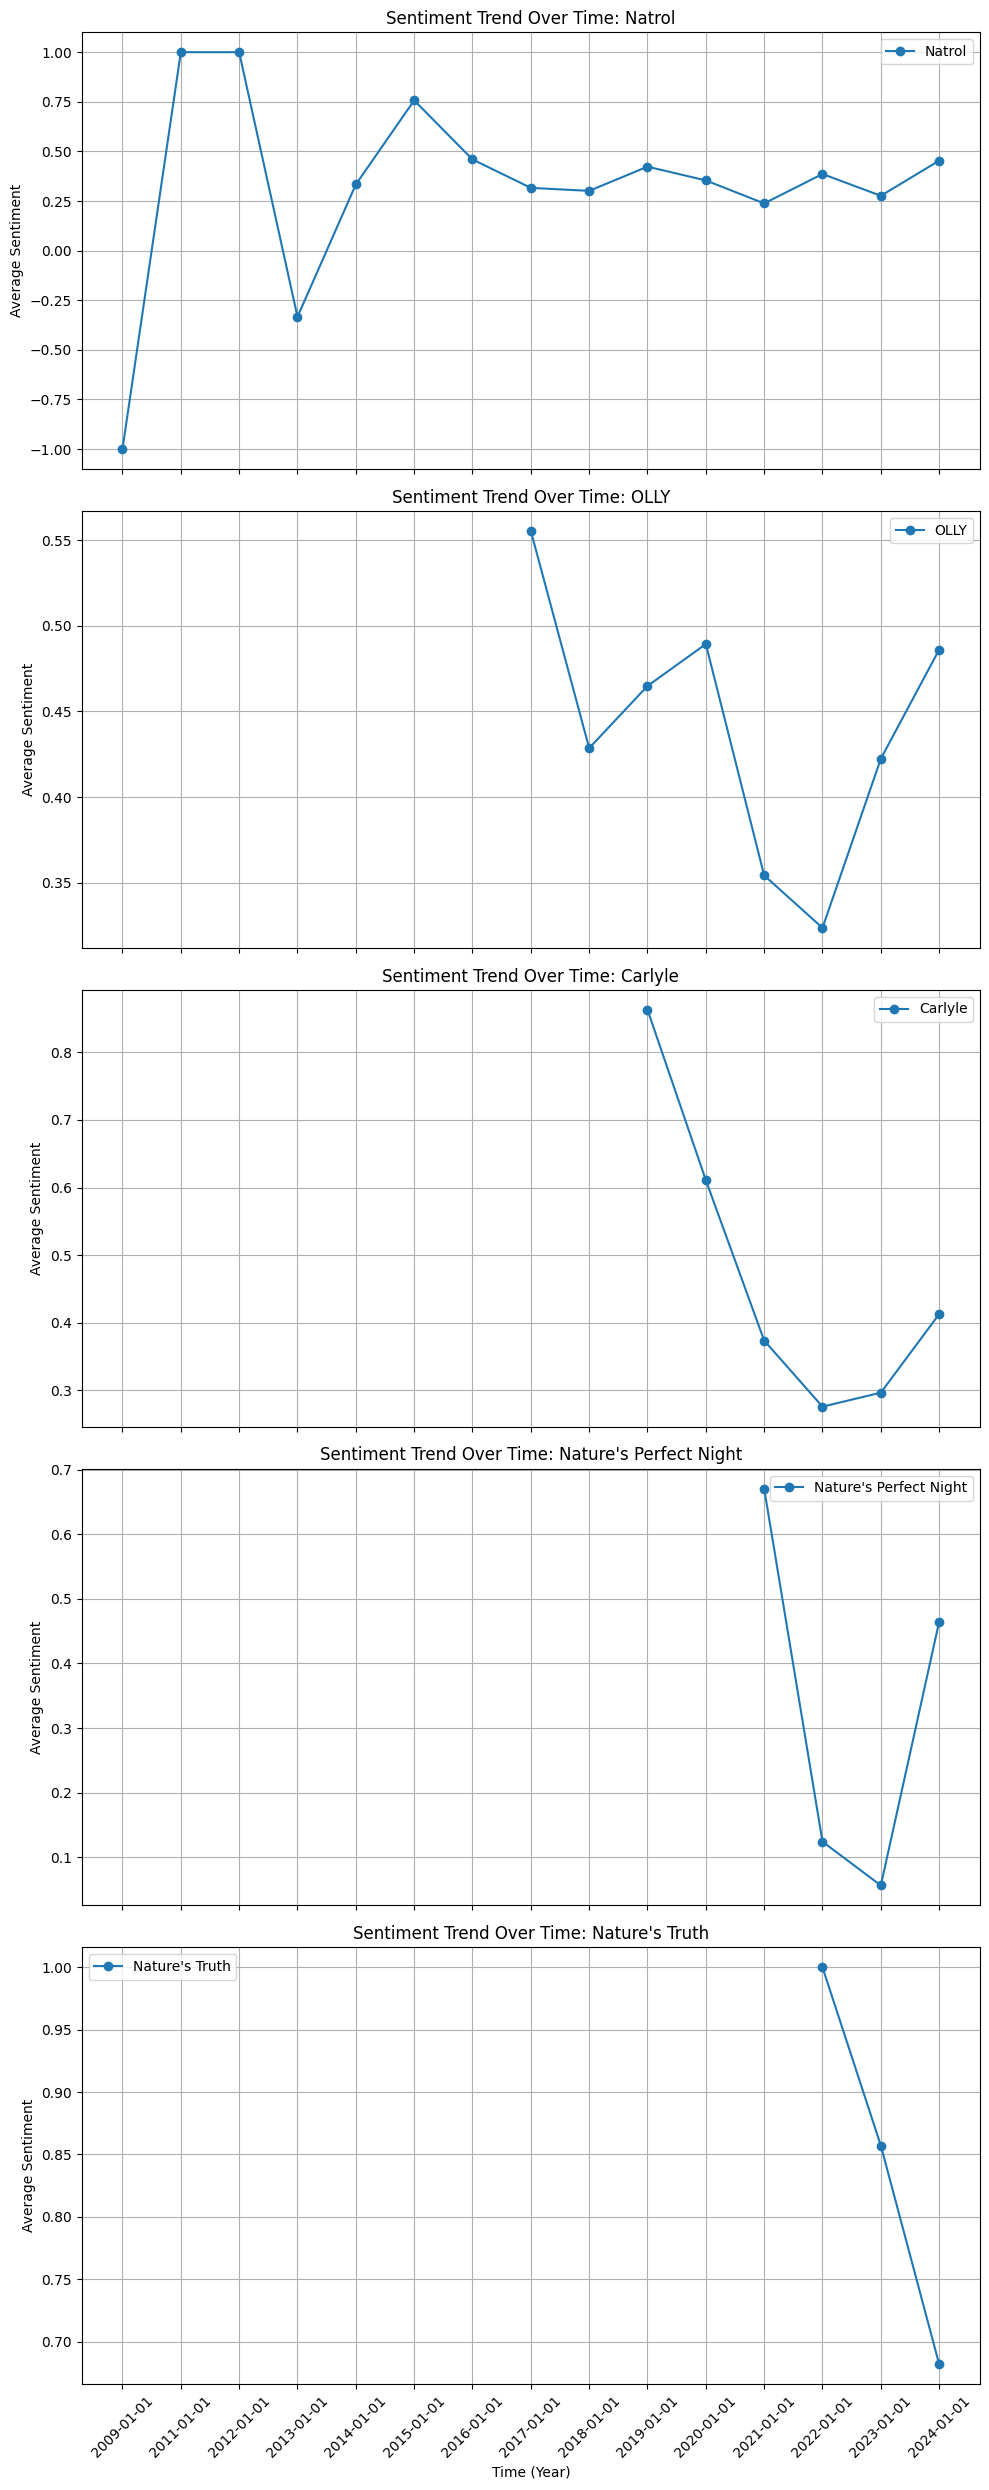

<Figure size 640x480 with 0 Axes>

In [70]:
final_df['ReviewDate'] = pd.to_datetime(final_df['ReviewDate'])

# Extract month-year for grouping
final_df['Year'] = final_df['ReviewDate'].dt.to_period('Y')
final_df['Sentiments_as_numbers'] = final_df['Sentiments'].map({'Positive': 1, 'Neutral': 0, 'Negative': -1})

# Group by brand and year, and calculate the mean sentiment
brand_sentiment_trends = final_df.groupby(['Brand', 'Year'])['Sentiments_as_numbers'].mean().reset_index()

# Sort by Year in ascending order
brand_sentiment_trends['Year'] = brand_sentiment_trends['Year'].dt.start_time  # Convert to datetime
brand_sentiment_trends = brand_sentiment_trends.sort_values('Year')

brands = brand_sentiment_trends['Brand'].unique()

# Plotting: One subplot per brand
fig, axes = plt.subplots(nrows=len(brands), figsize=(10, 5 * len(brands)), sharex=True)

for i, brand in enumerate(brands):
    brand_data = brand_sentiment_trends[brand_sentiment_trends['Brand'] == brand]
    ax = axes[i] if len(brands) > 1 else axes  # Handle single subplot case
    ax.plot(brand_data['Year'].astype(str), brand_data['Sentiments_as_numbers'], marker='o', label=brand)
    ax.set_title(f'Sentiment Trend Over Time: {brand}')
    ax.set_ylabel('Average Sentiment')
    ax.legend()
    ax.grid()

# Common X-axis label
plt.xlabel('Time (Year)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.savefig("mul_line_graphs.png", format="png", dpi=300, bbox_inches="tight")


#### The intensity of user emotions: statistics and analytical adjectives

In [68]:
nlp = spacy.load("en_core_web_sm")

def extract_adjectives(text):

    doc = nlp(text) 
    adjectives = [token.text for token in doc if token.pos_ == "ADJ"]

    return adjectives

In [69]:
final_df['Adjectives'] = final_df['ReviewContentClean'].apply(extract_adjectives)

In [70]:
# Add polarity for adjectives extracted from ReviewContentClean using the extract_adjectives() function
def extract_adjectives_polarity(text):

    adj_polarity = sum(TextBlob(adj).sentiment.polarity for adj in text) / len(text) if text else 0
    
    return adj_polarity

In [71]:
final_df['AdjectivesPolarity'] = final_df['Adjectives'].apply(extract_adjectives_polarity)

In [72]:
final_df.head()

,Brand,HelpfulCounts,ProductTitle,ReviewContent,ReviewScore,ReviewTitle,Verified,MG,ReviewMonth,ReviewDate,ReviewLength,ReviewContentClean,Subjectivity,Polarity,Sentiments,Year,Sentiments_as_numbers,Adjectives,AdjectivesPolarity
0,Natrol,NaN,"Natrol Fast Dissolve Melatonin 10 mg, Melatoni...",I like how they are chewable and almost start ...,5.0,Good sleep aid,True,10,November,2024-11-04,273,chewable almost start working immediately easy...,0.597222,0.227778,Positive,2024,1,"[chewable, easy, bad, adequate, great, many, c...",0.195238
1,Natrol,NaN,"Natrol Fast Dissolve Melatonin 10 mg, Melatoni...",The Natrol Melatonin 10mg Strawberry-Flavored ...,5.0,Natrol Melatonin 10mg - My Gateway to Restful ...,True,10,October,2023-10-31,2381,natrol 10mg strawberryflavored dietary supplem...,0.539600,0.319067,Positive,2023,1,"[dietary, restful, essential, routine, whydeli...",0.179892
2,Natrol,NaN,"Natrol Fast Dissolve Melatonin 10 mg, Melatoni...",These melatonin tablets are great for my sleep...,5.0,My New Sleep Remedy,True,10,August,2024-08-12,301,tablet great sleepless took getting used theyv...,0.500758,0.389394,Positive,2024,1,"[great, new, good, glad, second]",0.427273
3,Natrol,NaN,"Natrol Fast Dissolve Melatonin 10 mg, Melatoni...",Yes it helps sleep so is effective no side eff...,5.0,Frequent buyer,True,10,October,2024-10-11,175,yes help effective side effect easily chewed s...,0.726667,0.366667,Positive,2024,1,"[effective, swallow, fresh, largest, better, p...",0.233333
4,Natrol,NaN,"Natrol Fast Dissolve Melatonin 10 mg, Melatoni...",Flavor was not as good as others by this compa...,4.0,Work great but…,True,10,September,2024-09-09,97,flavor good others company tolerable bit surpr...,0.750000,0.400000,Positive,2024,1,"[good, tolerable, surprised]",0.266667


In [73]:
final_df['AdjectivesPolarity'].describe()

count    40858.000000
mean         0.117535
std          0.308711
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.259167
max          1.000000
Name: AdjectivesPolarity, dtype: float64

In [74]:
positive_adjectives = final_df[final_df['AdjectivesPolarity'] > 0]
positive_adjective_list = positive_adjectives['Adjectives'].explode()  # Flatten the list of positive adjectives
positive_adjective_counts = positive_adjective_list.value_counts()
positive_adjective_counts[0:10]

Adjectives
good         6193
great        5192
effective    1820
better       1511
different    1349
many         1326
easy         1144
next         1129
first        1052
little       1035
Name: count, dtype: int64

In [75]:
negative_adjectives = final_df[final_df['AdjectivesPolarity'] < 0]
negative_adjective_list = negative_adjectives['Adjectives'].explode()  # Flatten the list of negative adjectives
negative_adjective_counts = negative_adjective_list.value_counts()
negative_adjective_counts[0:10]

Adjectives
bad          2097
different     807
horrible      782
terrible      650
last          599
little        559
next          550
tired         519
awful         513
good          500
Name: count, dtype: int64

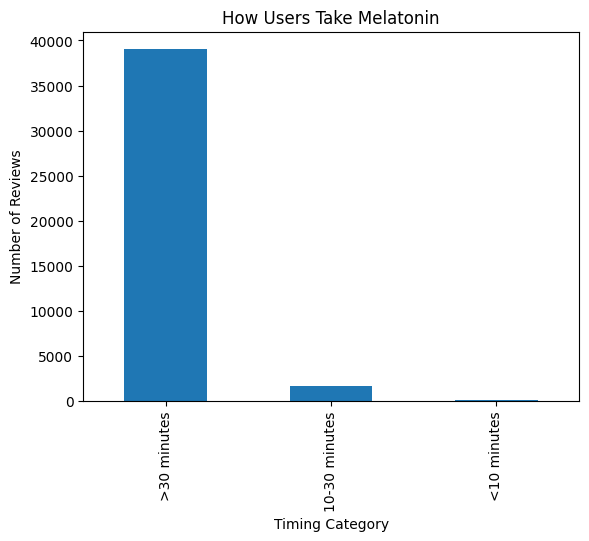

In [71]:
def extract_timing(review):
    match = re.search(r'(\d+)\s*minutes', review.lower())
    if match:
        return int(match.group(1))
    return None

final_df['Timing'] = final_df['ReviewContent'].apply(lambda x: extract_timing(str(x)))

def categorize_timing(minutes):
    if minutes is None:
        return 'No Mention'
    elif minutes <= 10:
        return '<10 minutes'
    elif 10 < minutes <= 30:
        return '10-30 minutes'
    else:
        return '>30 minutes'

final_df['TimingCategory'] = final_df['Timing'].apply(categorize_timing)

timing_counts = final_df['TimingCategory'].value_counts()

timing_counts.plot(kind='bar', title='How Users Take Melatonin')
plt.xlabel('Timing Category')
plt.ylabel('Number of Reviews')
plt.show()
